In [26]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.colors import NoNorm
import math

In [44]:
def read_image(filename, color=True):
  return cv2.cvtColor(cv2.imread(filename, 1 if color else 0), cv2.COLOR_BGR2RGB)

def write_image(filename, image_data):
  image_data = cv2.cvtColor(image_data, cv2.COLOR_RGB2BGR)
  cv2.imwrite(filename, image_data)

def show_image(image, title="sample", figsize=(8,6), tickoff=False):
  plt.figure(figsize=figsize)
  if image.ndim == 2:
      plt.imshow(image, cmap="gray", norm=NoNorm())
  else:
      plt.imshow(image)
  plt.title(title)
  plt.show()

def show_double_image(image1,image2, title="Sample",figsize=(8,6)):
  fig, (ax1, ax2) = plt.subplots(1, 2,figsize=figsize)
  fig.suptitle(title)
  ax1.imshow(image1,cmap="gray", norm=NoNorm())
  ax2.imshow(image2,cmap="gray", norm=NoNorm())

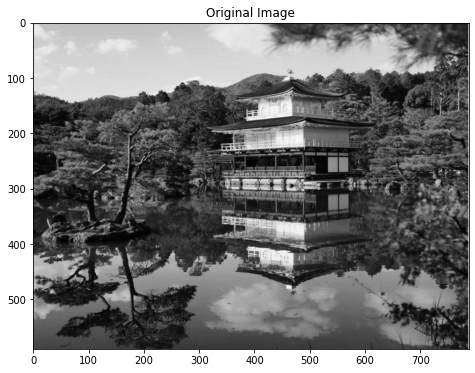

In [28]:
image = read_image("./images/kyoto.png", color=False)
image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
show_image(image_gray, "Original Image")

In [29]:
def convolve2d_arr(a:np.ndarray, kernel_size:int):
    '''
    segment an image into multiple sub matrix
    '''
    sub_shape = (kernel_size,kernel_size)
    view_shape = tuple(np.subtract(a.shape, sub_shape) + 1) + sub_shape
    strides = a.strides + a.strides
    sub_matrices = np.lib.stride_tricks.as_strided(a,view_shape,strides)
    return sub_matrices


<img src="markdownfigure/filter.png"><br>
Those filter need formula, from formula we can create an matrix for algorythm

In [121]:
def avegare_blur(input_image:np.ndarray, kernel_size:int) -> np.ndarray:
    kernel_matrix = (1/kernel_size**2) * np.ones(shape=(kernel_size,kernel_size)).astype(np.float32)
    segmented = convolve2d_arr(input_image,kernel_size)
    m = np.einsum('kl,ijkl->ij',kernel_matrix,segmented)
    return m.astype(np.uint8)

def edge_detecting_sobel(gray_image: np.ndarray):
    segmented = convolve2d_arr(gray_image,3)
    sobel_x = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
    sobel_y= np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
    m_x = np.einsum('kl,ijkl->ij',sobel_x,segmented)
    m_y = np.einsum('kl,ijkl->ij',sobel_y,segmented)
    return (m_x+m_y)

def gaussian_blur(input_image:np.ndarray,kernel_size:int,sigma:float)->np.ndarray:
    '''just for gray image'''
    abs_len_k = (kernel_size-1)/2
    h1, h2 = np.meshgrid(np.arange(-abs_len_k,abs_len_k+1,step=1), np.arange(-abs_len_k,abs_len_k+1,step=1))
    kernel_matrix = np.exp(- (h1**2+h2**2) / (2*sigma**2))
    kernel_matrix = kernel_matrix / np.sum(kernel_matrix)
    segmented = convolve2d_arr(input_image,kernel_size)
    m = np.einsum('kl,ijkl->ij',kernel_matrix,segmented)
    return m.astype(np.uint8)

def laplace_filter(gray_image: np.ndarray,alpha:float):
    '''sigma in range 0->1'''
    segmented = convolve2d_arr(gray_image,3)
    laplace_matrix = (4/(alpha+1))*np.array([[alpha/4,(1-alpha)/4,alpha/4],[(1-alpha)/4,-1,(1-alpha)/4],[alpha/4,(1-alpha)/4,alpha/4]])
    m = np.einsum('kl,ijkl->ij',laplace_matrix,segmented).astype(np.uint8)
    return m

def laplace_operator(image:np.ndarray,option:int,hb='hb4'):
    '''option 1 for Laplacian filter 3, option 2 for Laplacian sharpening filter, hb4 = high boost 4, hb8 = high boost 8'''
    segmented = convolve2d_arr(image,3)
    high_boost = {'hb4':4,'hb8':8}
    edge_matrix = {'hb4':0,'hb8':-1}
    laplace_matrix = None
    if (option == 1):
        laplace_matrix = np.array([[edge_matrix[hb],-1,edge_matrix[hb]],[-1,high_boost[hb],-1],[edge_matrix[hb],-1,edge_matrix[hb]]])
    else:
        laplace_matrix = np.array([[edge_matrix[hb],-1,edge_matrix[hb]],[-1,high_boost[hb]+1,-1],[edge_matrix[hb],-1,edge_matrix[hb]]])
    m = np.einsum('kl,ijkl->ij',laplace_matrix,segmented)
    return m

def unsharp_masking(image):
    f_sharpened = laplace_operator(image,1,'hb4')
    f_blurred_mean = avegare_blur(image,3)
    return -f_sharpened + f_blurred_mean

def laplace_of_gaussian(input_image,gauss_ksize=11, sigma=0.2, kappa=0.75, pad=False):
    img = gaussian_blur(input_image, gauss_ksize, sigma) if 0. < sigma else input_image
    img = laplace_operator(input_image, 1).astype(np.float64)
    rows, cols = img.shape[:2]
    min_map = np.minimum.reduce(list(img[r:rows-2+r, c:cols-2+c]
                                     for r in range(3) for c in range(3)))
    max_map = np.maximum.reduce(list(img[r:rows-2+r, c:cols-2+c]
                                     for r in range(3) for c in range(3)))
    # bool matrix for image value positiv (w/out border pixels)
    pos_img = 0 < img[1:rows-1, 1:cols-1]
    # bool matrix for min < 0 and 0 < image pixel
    neg_min = min_map < 0
    neg_min[1 - pos_img] = 0
    # bool matrix for 0 < max and image pixel < 0
    pos_max = 0 < max_map
    pos_max[pos_img] = 0
    # sign change at pixel?
    zero_cross = neg_min + pos_max
    # values: max - min, scaled to 0--255; set to 0 for no sign change
    value_scale = 255. / max(1., img.max() - img.min())
    values = value_scale * (max_map - min_map)
    values[1 - zero_cross] = 0.
    # optional thresholding
    if 0. <= kappa:
        thresh = float(np.absolute(img).mean()) * kappa
        values[values < thresh] = 0.
    log_img = values.astype(np.uint8)
    if pad:
        log_img = np.pad(log_img, pad_width=1, mode='constant', constant_values=0)
    return log_img



In [ ]:
show_image(avegare_blur(image_gray,10))
edgy_kids = edge_detecting_sobel(image_gray)
show_image(edgy_kids)

In [ ]:
a_board = read_image("./images/a_char.png", color=False)
a_board_gray = cv2.cvtColor(a_board, cv2.COLOR_RGB2GRAY)
show_double_image(avegare_blur(a_board_gray,5),avegare_blur(a_board_gray,31),'avegare_blur ks=5 vs ks=31',figsize=(11,5))
show_image(gaussian_blur(a_board_gray,11,0.5),"gaussian blur, k = 11, sigma 0.5")
show_image(laplace_filter(a_board_gray,0.2),"laplace filter, alpha 0.2")
show_double_image(laplace_operator(a_board_gray,1,'hb4'),laplace_operator(a_board_gray,1,'hb8'),'Laplacian sharpening filter, high boost 4 vs 8',figsize=(11,5))
show_double_image(a_board_gray,unsharp_masking(a_board_gray),"normal vs unsharp masking",figsize=(11,5))

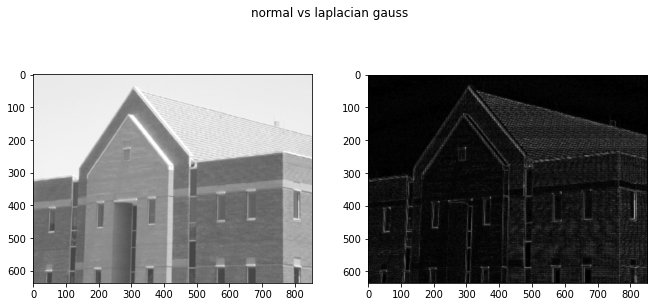

In [132]:
house = cv2.cvtColor(read_image("./images/house.png", color=False), cv2.COLOR_RGB2GRAY)
LoG_img = laplace_of_gaussian(house,gauss_ksize=25,sigma=0.9,kappa=0,pad=True)
show_double_image(house,LoG_img,"normal vs laplacian gauss",figsize=(11,5))


In [32]:
class Exp():
    pass

class IntLit(Exp):
    def __init__(self,value):
        self.value = value
    
    def eval(self):
        return self.value
        
class FloatLit(Exp):
    def __init__(self,value):
        self.value = value
    
    def eval(self):
        return self.value
        
class BinExp(Exp):
    def __init__(self,e1,op,e2):
        self.e1 = e1
        self.op = op
        self.e2 = e2
    
    def eval(self):
        e1 = self.e1.eval()
        e2 = self.e2.eval()
        if(self.op == '+'): return e1 + e2
        elif(self.op == '-'): return e1 - e2
        elif(self.op == '*'): return e1 * e2
        else: return e1 / e2
        
class UnExp(Exp):
    def __init__(self,op,e):
        self.e = e
        self.op = op
    
    def eval(self):
        e = self.e.eval()
        if(self.op == '+'): return e
        else: return -e